<a href="https://colab.research.google.com/github/satyam-tomar/neural-networks/blob/main/mnist_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST with TensorFlow


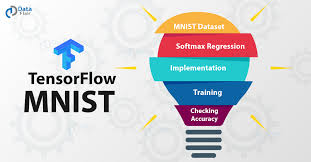

In [28]:
from IPython.display import display, Image
display(Image(filename="tensorflow.jpeg"))


This document provides a structured overview of implementing MNIST classification using TensorFlow, emphasizing **best practices, high-level APIs, and transferable concepts to transformers**. It focuses on mental models, steps, and API usage rather than code.

---

## 1. Project Structure and Workflow

TensorFlow projects follow a consistent mental model:

1. **Data pipeline** (`tf.data`)  
2. **Model definition** (`tf.keras`)  
3. **Compilation** (`compile`)  
4. **Training** (`fit`)  
5. **Evaluation and inference** (`evaluate` / `predict`)  
6. **Bridging to transformers**

---

## 2. Data Pipeline (`tf.data`)

TensorFlow encourages **lazy, graph-based input pipelines**.

**Key Steps:**
1. Convert raw data (NumPy arrays, files, generators) to a `tf.data.Dataset`.  
2. Transform elements with `.map()` (normalization, reshaping, tokenization).  
3. Shuffle for randomness: `.shuffle(buffer_size)`.  
4. Batch the dataset: `.batch(batch_size)`.  
5. Prefetch for performance: `.prefetch(buffer_size)`.

**Important Notes:**
- Pipeline order matters: `source → map → shuffle → batch → prefetch`.  
- Dataset elements are typically `(input, label)` tuples.  
- `tf.data` pipelines are agnostic to the model type (CNN, FNN, Transformer).

---

## 3. Model Definition (`tf.keras`)

TensorFlow separates **Layer vs Model**:

| Concept   | Description |
|-----------|-------------|
| Layer     | Reusable computation unit with weights (e.g., Dense, Embedding, Multi-Head Attention). |
| Model     | Container wiring layers, exposing train/eval/predict, and supporting callbacks. |

**Two main ways to define models:**

- **Sequential API:**  
  - Simple linear stack of layers  
  - Easy for beginners  
  - Limitation: cannot handle branching, residuals, multiple inputs  

- **Functional API:**  
  - Graph-based layer composition  
  - Flexible for complex architectures  
  - Essential for transformers and multimodal models  

**Key Points:**
- Layers create weights lazily when they first see input shapes.  
- Models are callable objects; forward pass is tracked automatically for gradients.  
- Models can be nested: e.g., transformer block as a Layer inside a larger Model.

---

## 4. Compilation (`compile`)

Binding **intent to execution**.

**Key Components:**
- **Loss function:** defines error (e.g., categorical cross-entropy).  
- **Optimizer:** handles weight updates (e.g., SGD, Adam).  
- **Metrics:** track performance independently from loss (e.g., accuracy).  

**Callbacks:**  
- Early stopping, learning rate schedules, checkpointing  
- Modular extensions replacing manual training loop interventions

---

## 5. Training (`fit`)

- TensorFlow abstracts forward pass, gradient computation, and weight update.  
- Mini-batch training enforced via `tf.data` pipeline.  
- Batch-first execution is standard, enabling large-scale datasets.  
- Metrics and logging handled automatically.  

**Mental shift from scratch:**
- Scratch: manual epoch/batch loops → compute gradients → update weights  
- TensorFlow: declare loss, optimizer, metrics → compile → fit

---

## 6. Evaluation and Inference

| Mode        | Purpose                                              | Key Behavior                                   |
|------------|------------------------------------------------------|-----------------------------------------------|
| Training   | Model learning                                       | Gradients computed, dropout/BatchNorm active  |
| Evaluation | Compute metrics without updating weights            | No gradient, training layers in eval mode     |
| Inference  | Predictions on new data                              | Forward pass only, deterministic outputs      |

- Important for MNIST validation and transformer sequence evaluation.

---

## 7. Bridging MNIST to Transformers

| Component         | MNIST Equivalent               | Transformer Equivalent                       |
|------------------|-------------------------------|----------------------------------------------|
| Dense layer       | Fully connected layer          | Embedding / Projection                        |
| Input pipeline    | Pixel batch from `tf.data`     | Tokenized sequences with masks               |
| Model compilation | `compile(loss, optimizer)`     | Same, often with complex loss / scheduler   |
| Training loop     | `fit`                         | Same, scalable to huge datasets             |
| Callbacks         | Checkpoints, EarlyStopping    | LR schedules, gradient clipping, logging    |

**Key Takeaway:** TensorFlow abstractions remain unchanged; only layers and input shapes differ.

---

## 8. Summary Steps for MNIST in TensorFlow

1. Load and preprocess data using `tf.data.Dataset`.  
2. Define layers and build the model (`Sequential` or `Functional`).  
3. Compile model with loss, optimizer, and metrics.  
4. Train using `fit` with dataset and callbacks.  
5. Evaluate and predict using `evaluate` and `predict`.  
6. Apply the same structure for transformer models, swapping layers and input processing.  
---

In [2]:
!pip install tensorflow

#Data Pipeline

In [3]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype("float32")/255.0
X_test = X_test.astype("float32") / 255.0

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#Model Definition

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

#Compile Model

In [6]:
# configuration (how should this model be trained)

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

#Train Model


In [25]:
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 5,
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
)

model.save("mnist_model.keras")
print("Model saved as mnist_model")

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9949 - loss: 0.0177 - val_accuracy: 0.9748 - val_loss: 0.0939
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.9782 - val_loss: 0.0877
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9966 - loss: 0.0121 - val_accuracy: 0.9750 - val_loss: 0.0995
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9783 - val_loss: 0.0959
Model saved as mnist_model


# What Actually Happens


When `model.fit()` is called, TensorFlow executes a standardized training loop.

The loop is **epoch-driven**, **batch-based**, and **pipeline-backed**.


## Training Loop (Conceptual Execution Order)

For each epoch:

1. TensorFlow requests the **next batch** from `tf.data.Dataset`
2. The dataset:
   - Takes **one sample at a time**
   - Applies `map()` transformations on the fly
   - Groups samples into a batch
3. The batch is passed to the model
4. Forward pass is executed
5. Loss is computed
6. Gradients are calculated automatically
7. Optimizer updates the weights
8. Metrics are updated
9. Callbacks are triggered

This repeats until the dataset is exhausted for the epoch.

---

##  How `tf.data.Dataset` Works

- `tf.data.Dataset` does **not** load the entire dataset into the model
- It produces **one element at a time**
- `map()` is applied **per sample, in real time**
- `batch()` only groups already-processed samples
- `prefetch()` prepares the **next batch while the current batch is training**

This means:
- Data preprocessing and model training run **in parallel**
- The GPU/CPU is not blocked waiting for data
- The pipeline scales naturally to large datasets


## Prefetch Behavior (Important)

While the model is training on batch `N`:

- `tf.data` is already preparing batch `N+1`
- Mapping, batching, and loading happen asynchronously
- This overlap is automatic and controlled by `prefetch()`



## Why This Design Matters

- No Python loops inside training
- Deterministic, reproducible execution
- Same pipeline works for:
  - MNIST
  - NLP token streams
  - Transformer attention masks
  - Large-scale distributed training

---

- `compile()` defines **how training should work**
- `fit()` executes **this exact loop**
- `tf.data.Dataset` feeds data **sample-by-sample, batch-by-batch, asynchronously**




#Evaluation and Inference

In [26]:
import tensorflow as tf

model = tf.keras.models.load_model("mnist_model.keras")

loss, acc = model.evaluate(test_ds)
print(acc)

predictions = model.predict(X_test[:5])


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9753 - loss: 0.1105
0.9782999753952026
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


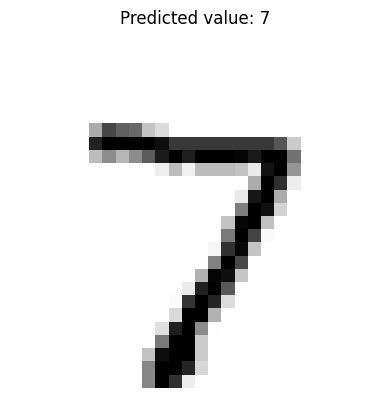

In [27]:
import matplotlib.pyplot as plt

sample_image = X_test[0]
plt.imshow(sample_image, cmap="binary")
plt.axis("off")
plt.title(f"Predicted value: {str(predicted_labels[0].numpy())}" )
plt.show()
